In [1]:
# Three helpers functions are used to preprocess the dataset, plot diagrams and to perform wavelet packet decompositions
# please check them under the helpers folder
from helpers.DatasetProcess import dataset_to_df
from helpers.PlotExtension import norm_to_plot, img_plot
from helpers.WaveletPacket import wpt_dec, plot_wpt_nodes, plot_wpt_fun, wavelet_families

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn

# Pytorch is used to build the model
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau , CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, recall_score, f1_score

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(7444889600, 8589410304)

### First: Load the Dataset and Get Some Statistics

In [4]:
# Define the Path of the Model
model_type = "vit"
weights_folder_path = "../weights"
model_folder = "CIFAKE"

checkpoint_folder = "WPT-ViT_Compare"

In [5]:
# file name of the saved model
fname1 = f"WPT-ViT_db2_L3P1H18E1S0B500D32_CIFAKE_ph1_lastEp200_acc65.53"
fname2 = f"WPT-ViT_db2_L3P1H18E1S0B1000D32_CIFAKE_ph1_lastEp200_acc92.42"
fname3 = f"WPT-ViT_db2_L3P1H18E1S0B2000D32_CIFAKE_ph1_lastEp200_acc87.63"
fname4 = f"WPT-ViT_db2_L3P1H18E1S1B1000D32_CIFAKE_ph1_lastEp200_acc91.62"
fname5 = f"WPT-ViT_haar_L3P1H16E2S0B1000D32_CIFAKE_ph2_lastEp200_acc91.18"
fname6 = f"WPT-ViT_haar_L3P1H16E1S1B1000D32_CIFAKE_ph1_lastEp200_acc89.63"

fname_lst = [fname1, fname2, fname3, fname4, fname5, fname6]

In [6]:
paramsize1 = 207,686
paramsize2 = 207,686
paramsize3 = 207,686
paramsize4 = 201,854
paramsize5 = 80,978
paramsize6 = 40,754



In [7]:
label_lst=["db2: All_Coeff, 1 Enc, BatchSize 500","db2: All_Coeff, 1 Enc, BatchSize 1000","db2: All_Coeff, 1 Enc, BatchSize 2000","db2: Sampled_Coeff, 1 Enc, BatchSize 1000","haar: All_Coeff, 2 Enc, BatchSize 1000","haar: Sampled_Coeff, 1 Enc, BatchSize 1000"]

In [8]:
model_state_path = f"{weights_folder_path}/{model_folder}/{checkpoint_folder}/"

In [9]:
checkpoint = [""]*len(fname_lst)
for i in range(len(fname_lst)):
    checkpoint[i] = torch.load(model_state_path+fname_lst[i])

In [10]:
best_acc_ofModel=[""]*len(fname_lst)
models_epoch_lst_ofModel=[""]*len(fname_lst)
tr_loss_lst_ofModel=[""]*len(fname_lst)
tr_acc_lst_ofModel=[""]*len(fname_lst)
val_loss_lst_ofModel=[""]*len(fname_lst)
val_acc_lst_ofModel=[""]*len(fname_lst)
accumulate_duration_lst_ofModel=[""]*len(fname_lst)

In [11]:
for i in range(len(fname_lst)):
    best_acc_ofModel[i] = checkpoint[i]['best_acc']
    models_epoch_lst_ofModel[i] = checkpoint[i]['epoch_lst']
    tr_loss_lst_ofModel[i] = checkpoint[i]['tr_loss_lst']
    tr_acc_lst_ofModel[i] = checkpoint[i]['tr_acc_lst']
    val_loss_lst_ofModel[i] = checkpoint[i]['val_loss_lst']
    val_acc_lst_ofModel[i] = checkpoint[i]['val_acc_lst']
    accumulate_duration_lst_ofModel[i] = checkpoint[i]['accumulate_duration_lst']

In [12]:
grid_step = 20

In [13]:
x= range(len(tr_loss_lst_ofModel[0]))

In [14]:
# fig, axs = plt.subplots(2, 2,sharex=True,figsize=(14,10))

# axs[0,0].plot(x, tr_loss_lst_ofModel[0], label=label_lst[0]+' Train Loss')
# axs[0,0].plot(x, tr_loss_lst_ofModel[1], label=label_lst[1]+' Train Loss')
# axs[0,0].plot(x, tr_loss_lst_ofModel[2], label=label_lst[2]+' Train Loss')
# axs[0,0].plot(x, tr_loss_lst_ofModel[3], label=label_lst[3]+' Train Loss')
# axs[0,0].plot(x, tr_loss_lst_ofModel[4], label=label_lst[4]+' Train Loss')
# axs[0,0].plot(x, tr_loss_lst_ofModel[5], label=label_lst[5]+' Train Loss')
# axs[0,0].grid(True)
# axs[0,0].set_ylim([0, 1.1])
# axs[0,0].legend(loc='upper right')
# axs[0,0].set_xlabel('Epochs')
# axs[0,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


# axs[0,1].plot(x, val_loss_lst_ofModel[0], label=label_lst[0]+' Validation Loss')
# axs[0,1].plot(x, val_loss_lst_ofModel[1], label=label_lst[1]+' Validation Loss')
# axs[0,1].plot(x, val_loss_lst_ofModel[2], label=label_lst[2]+' Validation Loss')
# axs[0,1].plot(x, val_loss_lst_ofModel[3], label=label_lst[3]+' Validation Loss')
# axs[0,1].plot(x, val_loss_lst_ofModel[4], label=label_lst[4]+' Validation Loss')
# axs[0,1].plot(x, val_loss_lst_ofModel[5], label=label_lst[5]+' Validation Loss')
# axs[0,1].grid(True)
# axs[0,1].set_ylim([0, 1.1])
# axs[0,1].legend(loc='upper right')
# axs[0,1].set_xlabel('Epochs')
# axs[0,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


# axs[1,0].plot(x, tr_acc_lst_ofModel[0], label=label_lst[0]+' Train Accuracy')
# axs[1,0].plot(x, tr_acc_lst_ofModel[1], label=label_lst[1]+' Train Accuracy')
# axs[1,0].plot(x, tr_acc_lst_ofModel[2], label=label_lst[2]+' Train Accuracy')
# axs[1,0].plot(x, tr_acc_lst_ofModel[3], label=label_lst[3]+' Train Accuracy')
# axs[1,0].plot(x, tr_acc_lst_ofModel[4], label=label_lst[4]+' Train Accuracy')
# axs[1,0].plot(x, tr_acc_lst_ofModel[5], label=label_lst[5]+' Train Accuracy')
# axs[1,0].grid(True)
# axs[1,0].set_ylim([40, 100])
# axs[1,0].legend(loc='lower right')
# axs[1,0].set_xlabel('Epochs')
# axs[1,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


# axs[1,1].plot(x, val_acc_lst_ofModel[0], label=label_lst[0]+' Validation Accuracy')
# axs[1,1].plot(x, val_acc_lst_ofModel[1], label=label_lst[1]+' Validation Accuracy')
# axs[1,1].plot(x, val_acc_lst_ofModel[2], label=label_lst[2]+' Validation Accuracy')
# axs[1,1].plot(x, val_acc_lst_ofModel[3], label=label_lst[3]+' Validation Accuracy')
# axs[1,1].plot(x, val_acc_lst_ofModel[4], label=label_lst[4]+' Validation Accuracy')
# axs[1,1].plot(x, val_acc_lst_ofModel[5], label=label_lst[5]+' Validation Accuracy')
# axs[1,1].grid(True)
# axs[1,1].set_ylim([40, 100])
# axs[1,1].legend(loc='lower right')
# axs[1,1].set_xlabel('Epochs')
# axs[1,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


# plt.show()

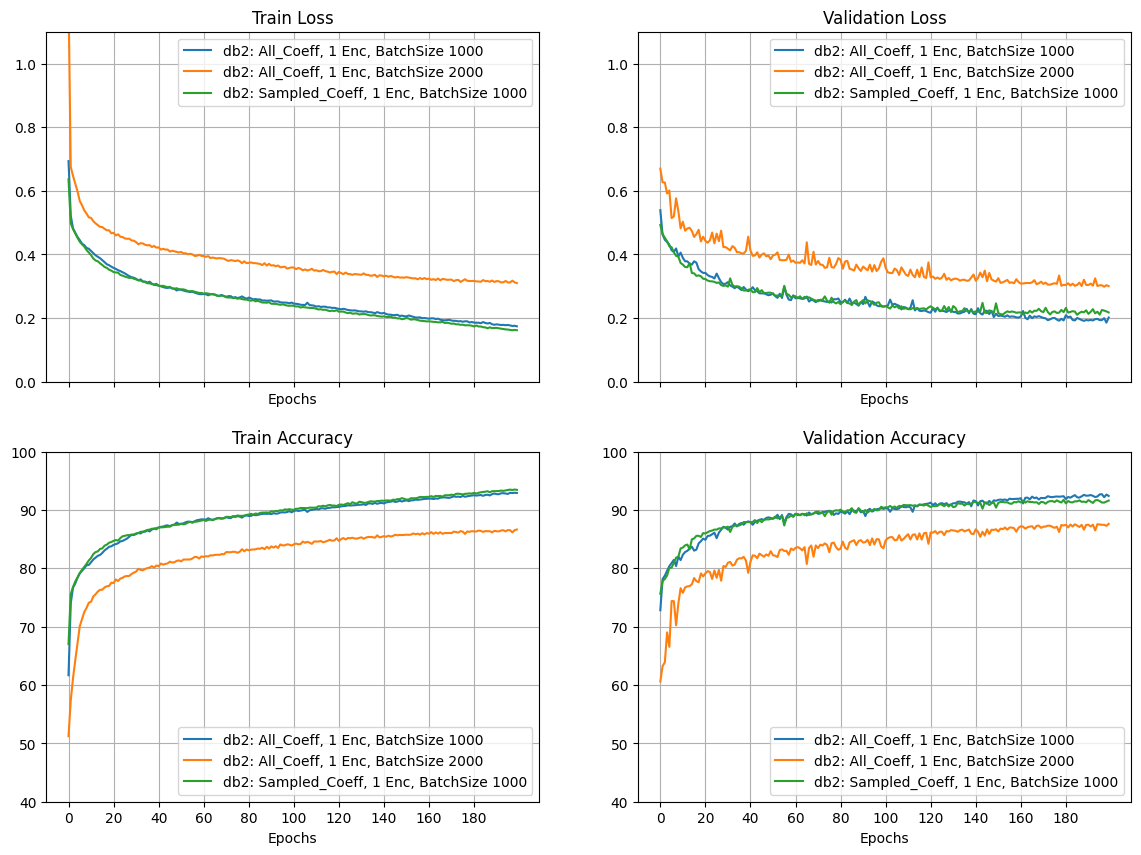

In [15]:
fig, axs = plt.subplots(2, 2,sharex=True,figsize=(14,10))

# axs[0,0].plot(x, tr_loss_lst_ofModel[0], label=label_lst[0])
axs[0,0].plot(x, tr_loss_lst_ofModel[1], label=label_lst[1])
axs[0,0].plot(x, tr_loss_lst_ofModel[2], label=label_lst[2])
axs[0,0].plot(x, tr_loss_lst_ofModel[3], label=label_lst[3])
# axs[0,0].plot(x, tr_loss_lst_ofModel[4], label=label_lst[4])
# axs[0,0].plot(x, tr_loss_lst_ofModel[5], label=label_lst[5])
axs[0,0].grid(True)
axs[0,0].set_ylim([0, 1.1])
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[0,0].set_title("Train Loss")

# axs[0,1].plot(x, val_loss_lst_ofModel[0], label=label_lst[0])
axs[0,1].plot(x, val_loss_lst_ofModel[1], label=label_lst[1])
axs[0,1].plot(x, val_loss_lst_ofModel[2], label=label_lst[2])
axs[0,1].plot(x, val_loss_lst_ofModel[3], label=label_lst[3])
# axs[0,1].plot(x, val_loss_lst_ofModel[4], label=label_lst[4])
# axs[0,1].plot(x, val_loss_lst_ofModel[5], label=label_lst[5])
axs[0,1].grid(True)
axs[0,1].set_ylim([0, 1.1])
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[0,1].set_title("Validation Loss")

# axs[1,0].plot(x, tr_acc_lst_ofModel[0], label=label_lst[0])
axs[1,0].plot(x, tr_acc_lst_ofModel[1], label=label_lst[1])
axs[1,0].plot(x, tr_acc_lst_ofModel[2], label=label_lst[2])
axs[1,0].plot(x, tr_acc_lst_ofModel[3], label=label_lst[3])
# axs[1,0].plot(x, tr_acc_lst_ofModel[4], label=label_lst[4])
# axs[1,0].plot(x, tr_acc_lst_ofModel[5], label=label_lst[5])
axs[1,0].grid(True)
axs[1,0].set_ylim([40, 100])
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[1,0].set_title("Train Accuracy")


# axs[1,1].plot(x, val_acc_lst_ofModel[0], label=label_lst[0])
axs[1,1].plot(x, val_acc_lst_ofModel[1], label=label_lst[1])
axs[1,1].plot(x, val_acc_lst_ofModel[2], label=label_lst[2])
axs[1,1].plot(x, val_acc_lst_ofModel[3], label=label_lst[3])
# axs[1,1].plot(x, val_acc_lst_ofModel[4], label=label_lst[4])
# axs[1,1].plot(x, val_acc_lst_ofModel[5], label=label_lst[5])
axs[1,1].grid(True)
axs[1,1].set_ylim([40, 100])
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[1,1].set_title("Validation Accuracy")


plt.show()

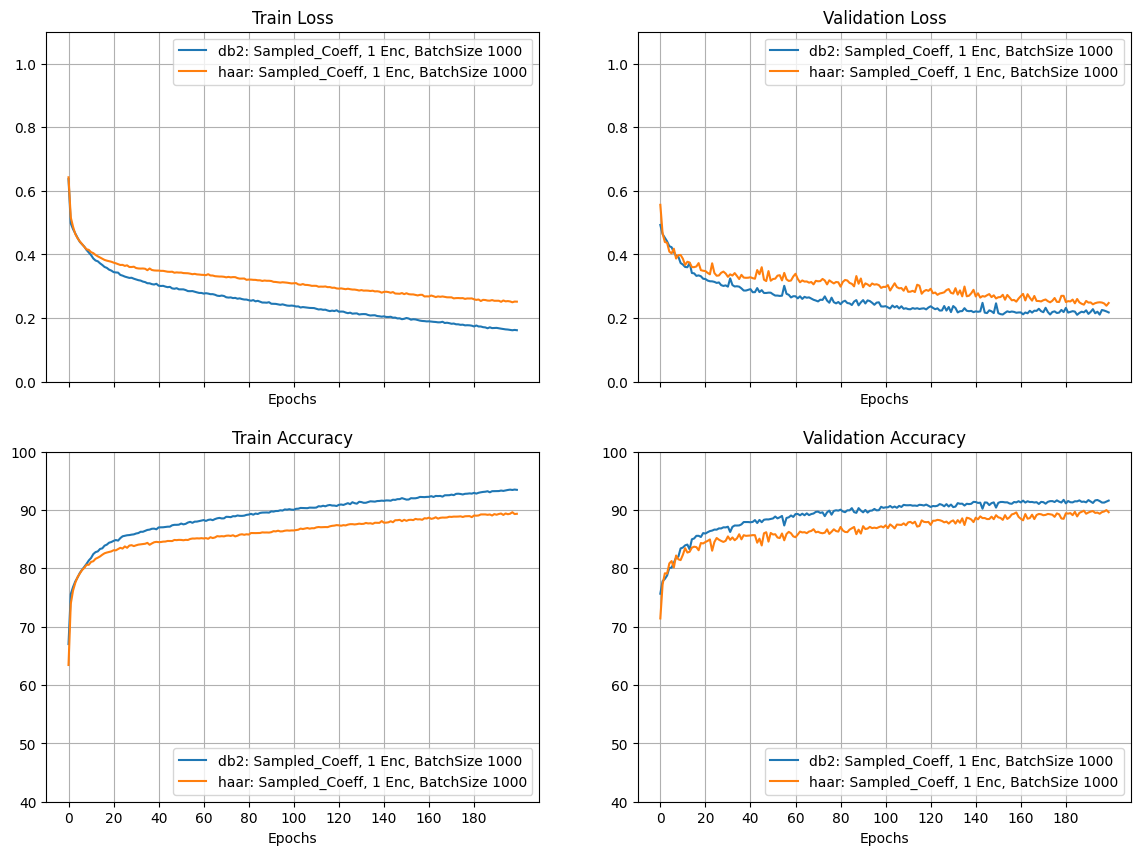

In [16]:
fig, axs = plt.subplots(2, 2,sharex=True,figsize=(14,10))

# axs[0,0].plot(x, tr_loss_lst_ofModel[0], label=label_lst[0])
# axs[0,0].plot(x, tr_loss_lst_ofModel[1], label=label_lst[1])
# axs[0,0].plot(x, tr_loss_lst_ofModel[2], label=label_lst[2])
axs[0,0].plot(x, tr_loss_lst_ofModel[3], label=label_lst[3])
# axs[0,0].plot(x, tr_loss_lst_ofModel[4], label=label_lst[4])
axs[0,0].plot(x, tr_loss_lst_ofModel[5], label=label_lst[5])
axs[0,0].grid(True)
axs[0,0].set_ylim([0, 1.1])
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[0,0].set_title("Train Loss")

# axs[0,1].plot(x, val_loss_lst_ofModel[0], label=label_lst[0])
# axs[0,1].plot(x, val_loss_lst_ofModel[1], label=label_lst[1])
# axs[0,1].plot(x, val_loss_lst_ofModel[2], label=label_lst[2])
axs[0,1].plot(x, val_loss_lst_ofModel[3], label=label_lst[3])
# axs[0,1].plot(x, val_loss_lst_ofModel[4], label=label_lst[4])
axs[0,1].plot(x, val_loss_lst_ofModel[5], label=label_lst[5])
axs[0,1].grid(True)
axs[0,1].set_ylim([0, 1.1])
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[0,1].set_title("Validation Loss")

# axs[1,0].plot(x, tr_acc_lst_ofModel[0], label=label_lst[0])
# axs[1,0].plot(x, tr_acc_lst_ofModel[1], label=label_lst[1])
# axs[1,0].plot(x, tr_acc_lst_ofModel[2], label=label_lst[2])
axs[1,0].plot(x, tr_acc_lst_ofModel[3], label=label_lst[3])
# axs[1,0].plot(x, tr_acc_lst_ofModel[4], label=label_lst[4])
axs[1,0].plot(x, tr_acc_lst_ofModel[5], label=label_lst[5])
axs[1,0].grid(True)
axs[1,0].set_ylim([40, 100])
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[1,0].set_title("Train Accuracy")


# axs[1,1].plot(x, val_acc_lst_ofModel[0], label=label_lst[0])
# axs[1,1].plot(x, val_acc_lst_ofModel[1], label=label_lst[1])
# axs[1,1].plot(x, val_acc_lst_ofModel[2], label=label_lst[2])
axs[1,1].plot(x, val_acc_lst_ofModel[3], label=label_lst[3])
# axs[1,1].plot(x, val_acc_lst_ofModel[4], label=label_lst[4])
axs[1,1].plot(x, val_acc_lst_ofModel[5], label=label_lst[5])
axs[1,1].grid(True)
axs[1,1].set_ylim([40, 100])
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))
axs[1,1].set_title("Validation Accuracy")


plt.show()

In [39]:
acc_list=[""]*len(fname_lst)
index_list=[""]*len(fname_lst)
time_list=[""]*len(fname_lst)
time_list2=[""]*len(fname_lst)
for i in range(len(fname_lst)):
    acc_list[i]=max(val_acc_lst_ofModel[i])
    index_list[i]=val_acc_lst_ofModel[i].index(acc_list[i])


In [40]:
acc_list

[87.335, 92.715, 87.63, 91.75, 92.175, 89.99]

In [41]:
index_list

[87, 196, 199, 179, 187, 198]

In [42]:
import time

In [45]:
for i in range(len(fname_lst)):
    time_list[i]=accumulate_duration_lst_ofModel[i][index_list[i]]
    time_list2[i]=time.strftime("%H:%M:%S", time.gmtime(time_list[i]))
    # time_list[i]=time.strftime("%H:%M:%S", )

time_list2

['00:29:45', '01:01:55', '01:04:21', '00:25:25', '01:15:39', '00:23:09']

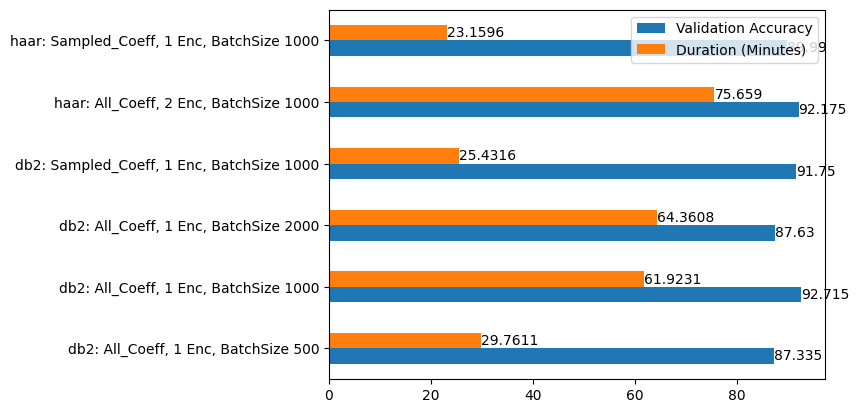

In [66]:
df = pd.DataFrame({'Validation Accuracy': acc_list, 'Duration (Minutes)': np.array(time_list)/60}, index=label_lst)
ax = df.plot.barh()
for container in ax.containers:
    ax.bar_label(container)

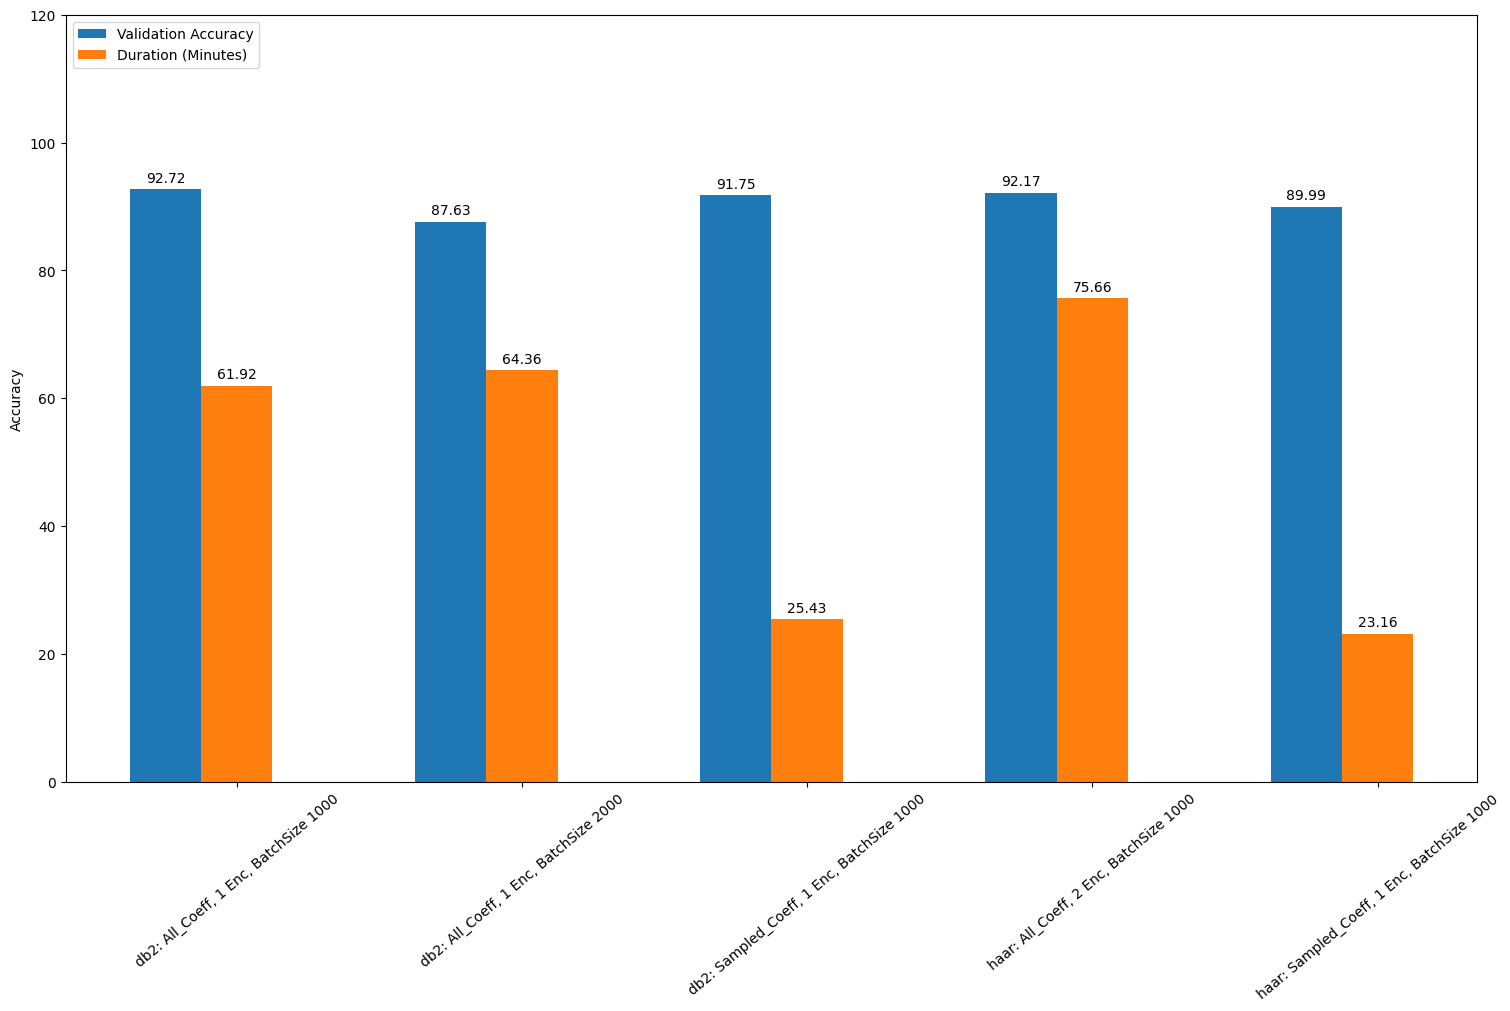

In [97]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = label_lst[1:]
penguin_means = {
    'Validation Accuracy': acc_list[1:],
    'Duration (Minutes)': list(np.array(time_list[1:])/60),
    # 'Epochs': e,
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier =0

fig, ax = plt.subplots(layout='constrained',figsize=(15,10))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3,fmt='%.2f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
# ax.set_title('C')
ax.set_xticks(x + width, species)

ax.tick_params(axis='x', labelrotation = 40)
 

ax.legend(loc='upper left')#, ncols=3)
ax.set_ylim(0, 120)

plt.show()

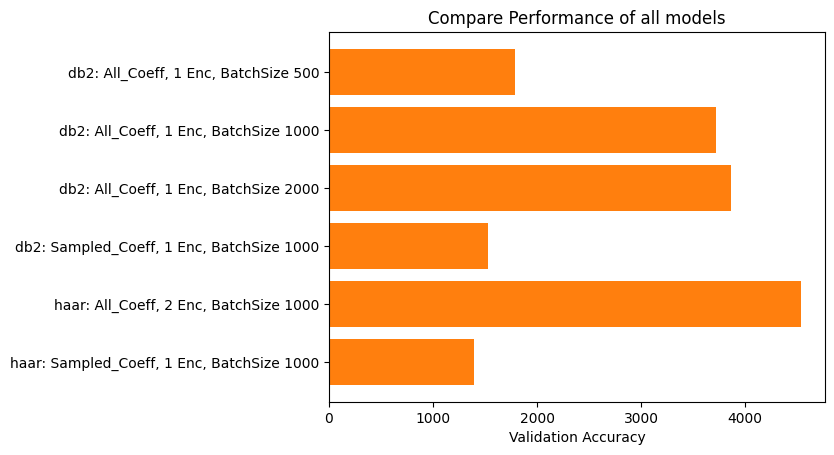

In [80]:
fig, ax = plt.subplots()

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = range(len(fname_lst))
# performance = 3 + 10 * np.random.rand(len(people))
# error = np.random.rand(len(people))

ax.barh(y_pos, acc_list, align='center')
ax.barh(y_pos, time_list, align='center')
ax.set_yticks(y_pos, labels=label_lst)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Validation Accuracy')
ax.set_title('Compare Performance of all models')

plt.show()